In [179]:
from pandas import *
import pandas
print pandas.__version__
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime
from geopy.geocoders import Nominatim

import re

geolocator = Nominatim()

%matplotlib inline
matplotlib.style.use('fivethirtyeight')




0.19.2


## Load datas


In [2]:
weather = read_csv('201402_babs_open_data/201402_weather_data.csv',index_col=0,parse_dates=True)


In [8]:
#status = read_csv('201402_babs_open_data/201402_status_data.csv',index_col=0,parse_dates=True)


In [3]:
stations = read_csv('201402_babs_open_data/201402_station_data.csv',index_col=0,parse_dates=True)


In [4]:
trips = read_csv('201402_babs_open_data/201402_trip_data.csv',index_col=0,parse_dates=True)

In [19]:
# separate date and time to two different columns
def take_time(dt):
    d=datetime.strptime(dt, '%m/%d/%Y %H:%M')
    return d.strftime('%H:%M')
    
def take_date(dt):
    d=datetime.strptime(dt, '%m/%d/%Y %H:%M')
    return d.strftime('%Y-%m-%d')


In [0]:
# status.loc[:,"Date"]=status.time.apply(take_date)
# status.loc[:,"time"]=status.time.apply(take_time)
# status.Date=status.Date.apply(to_datetime)
# status.time=status.time.apply(to_datetime)


In [69]:
trips_start = trips.loc[:,['Start Date','Start Terminal']]
trips_start.loc[:,'Start Date'] = trips_start.loc[:,'Start Date'].apply(to_datetime)
trips_start.loc[:,"Date"] = trips_start.loc[:,'Start Date'].dt.date.apply(to_datetime)

In [68]:
# Need internet connection to work!!
# Transfer zip codes to coordinates.
# Instead of apply function to all, it is faster
# to apply to unique values of zip the merge
zcit = Series(weather.zip.unique())

def zip2coor(x):
    loca = geolocator.geocode('CA:'+str(x),timeout=20) 
    # as we are in California added CA:. otherwise work not in all cases
    return Series({'lat':loca.latitude,'long':loca.longitude, 'zip':int(x)})

zipcoor = zcit.apply(zip2coor)
zipcoor.zip = zipcoor.zip.apply(int) #make zip int instead of float.
b = weather.reset_index().merge(zipcoor, on='zip').set_index('Date') #add coordinates to weather

In [70]:
weather_small = b.loc[:,['Max_Temperature_F','Events','lat','long']]


In [71]:
weather_small = weather_small.rename(columns={"lat": "lat_cit", "long": "long_cit"})

In [72]:
# the function distance do not use Internet
from geopy.distance import vincenty

coorstat = stations.loc[:,['lat','long']]
stations.loc[:,'st_id'] =stations.index

def get_cit_coor(x):
    c_stat = (x[0],x[1])
    mdist=1000
    for i in xrange(zipcoor.size):
        c_city = (zipcoor.lat[0],zipcoor.long[0])
        dist = vincenty(c_city, c_stat).kilometers
        if dist < mdist:
            mdist = dist
            coor=c_city
    return Series({'lat':x[0],'long':x[1],'lat_cit':coor[0],'long_cit':coor[1]})

a = stations.ix[:,'lat':'long'].apply(get_cit_coor,axis=1)
a = stations.merge(a,on=['lat','long'])


In [73]:
stations_small=a.loc[:,['lat','long','lat_cit','long_cit','landmark','st_id']]


In [75]:
trips_start = trips_start.rename(columns={"Start Terminal": "st_id", "Start Date": "date_time"})

In [76]:
result_small = trips_start.merge(stations_small, on='st_id')

In [77]:
weather_small.ix[:,'Date']=weather_small.index

In [78]:
result_small = result_small.merge(weather_small, on=['Date','lat_cit','long_cit'])

In [80]:
result_small.Events[result_small.Events=='rain'] = 'Rain'

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [81]:
result_small.Events[isnull(result_small.Events)]='Sun'

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [82]:
result_small['day_of_week'] = result_small['Date'].dt.weekday_name

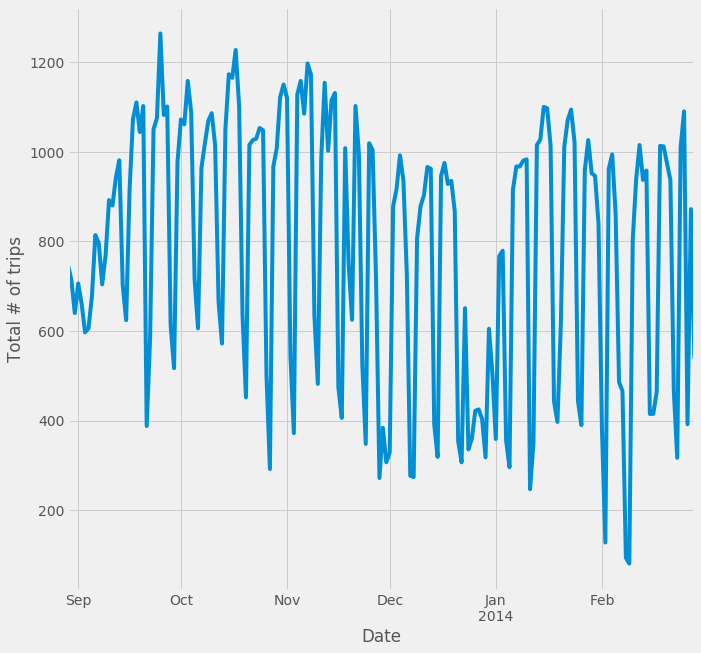

In [189]:
result_small.groupby('Date').size().plot(figsize=(10, 10))
plt.ylabel("Total # of trips")

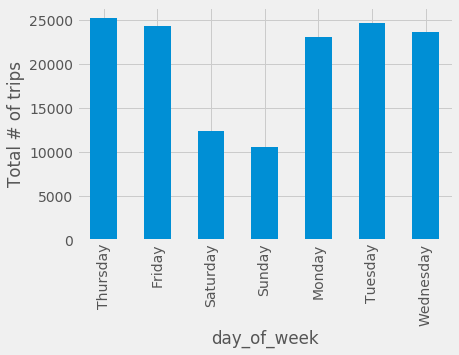

In [183]:
result_small.groupby('day_of_week',sort=False).size().plot('bar')
plt.ylabel("Total # of trips")

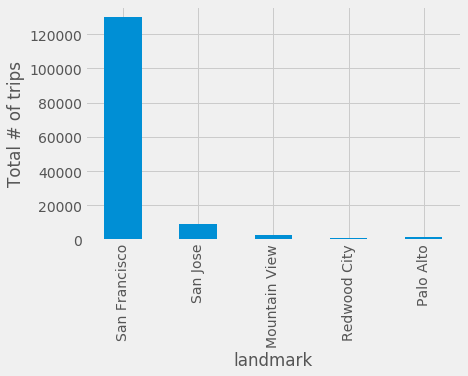

In [185]:
result_small.groupby('landmark',sort=False).size().plot.bar()
plt.ylabel("Total # of trips")

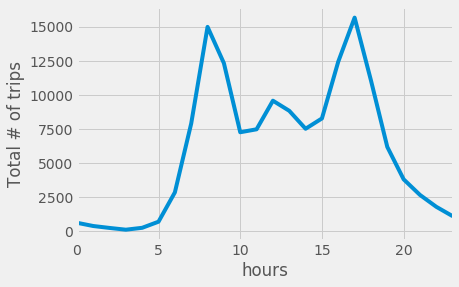

In [182]:
result_small.loc[:,'hours'] = result_small.date_time.dt.hour
result_small.groupby('hours').size().plot()
plt.ylabel("Total # of trips")

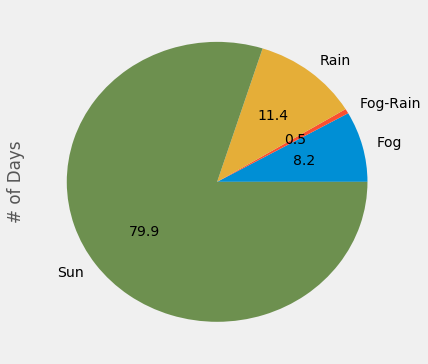

In [188]:
EvDa = result_small.groupby(['Events','Date']).size()
EvDa.groupby(level=0).size().plot.pie(autopct='%.1f', figsize=(6, 6))
plt.ylabel("# of Days")


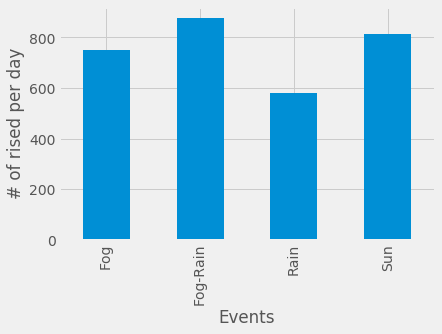

In [180]:
EvDa = result_small.groupby(['Events','Date']).size()
Days = EvDa.groupby(level=0).size()
Ev   = result_small.groupby('Events').size()
Ev.div(Days).plot.bar()
plt.ylabel("# of rised per day")


In [0]:

# def coor2zip(x):
#     loc  = geolocator.reverse(str(x[0])+", "+str(x[1]))
#     zips=str(loc.raw['address']['postcode'])
#     intzip=re.findall(r"[0-9]{5}", zips)
#     return int(intzip[0])

# stations.ix[:,'zip'] = stations.ix[:,'lat':'long'].apply(coor2zip,axis=1)

In [0]:
# from geopy import distance

# zcities = weather.zip.unique()
# zstations = stations.zip.unique()

# def zipdist(zip1,zip2):
#     #return distance between two zip codes
#     d = distance.distance
#     _, wa = geolocator.geocode(zip1,timeout=20)
#     _, pa = geolocator.geocode(zip2,timeout=20)
#     return (d(wa, pa)).kilometers

# def zcit_2_zst(sta,cit):
#     # return pandas Dataframe of correspondence between zip codes
#     # TODO: can be made faster
#     ziptab = {}
#     for i in sta:
#         mdist = 1e4
#         zm = 0
#         for j in cit:
#             dist = zipdist(i,j)
#             if dist < mdist:
#                 mdist = dist
#                 zm    = j
#         print i,j,mdist,zm
#         ziptab[str(i)] = zm
#     return DataFrame(data=ziptab,index=['zipc']).transpose()

# ziptab = zcit_2_zst(zstations,zcities)

95110 95113 0.748799354457 95113


95128 95113 1947.74837738 94301


95113 95113 0.0 95113


95112 95113 0.649942724697 95113


94063 95113 0.0 94063


94041 95113 0.0 94041


94040 95113 1.00891390089 94041


94301 95113 0.0 94301


94306 95113 6.1705619585 94041


94102 95113 1.57853241827 94107


94109 95113 2.95810620017 94107


94111 95113 1.40276982853 94107


94133 95113 2.20261187215 94107


94108 95113 1.07739447787 94107


94105 95113 0.831962715078 94107


94107 95113 0.0 94107


94103 95113 1.32237174194 94107


94118 95113 4.87900920235 94107


94124 95113 7.37773835065 94107


94104 95113 0.37776864997 94107


95126 95113 1945.83298315 94301
